# CS436 Project: 3D Scene Reconstruction
## Week 3: Incremental SfM + (Optional) Bundle Adjustment

### Objective
Implement an incremental Structure-from-Motion (SfM) pipeline that:
- Initializes a two-view reconstruction (matches → E-matrix → pose → triangulation).
- Adds subsequent views using PnP with 2D–3D correspondences.
- Triangulates new points to grow the map.
- Optionally refines camera poses and 3D points via bundle adjustment.

Outputs a sparse 3D point cloud (`reconstruction_raw.ply`) and, when enough observations exist, a refined point cloud (`reconstruction_refined.ply`).

# Imports and Setup

In [2]:
import os, sys, numpy as np
project_root = os.path.abspath(os.path.join('..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
from utils import load_images_from_folder
from reconstruction import get_intrinsic_matrix
from sfm import IncrementalSfM, run_bundle_adjustment
print('Modules loaded.')

Modules loaded.


# Initialize Dataset and Incremental SfM

In [3]:
DATA_DIR = '../data'
images = load_images_from_folder(DATA_DIR)
assert len(images) >= 2, 'Need at least two images.'
K = get_intrinsic_matrix(images[0].shape)
sfm = IncrementalSfM(images, K)
sfm.initialize_structure(0, 1)

registered = 2
for view_idx in range(2, len(images)):
    if sfm.process_next_view(view_idx):
        registered += 1
print(f'Incremental SfM processed {registered} views and produced {len(sfm.point_cloud)} points.')
sfm.save_ply('reconstruction_raw.ply')

Successfully loaded 28 images from ../data
Images resized to max width: 1024px
Incremental SfM processed 10 views and produced 1649 points.
Incremental SfM processed 10 views and produced 1649 points.


# Optional Bundle Adjustment

In [ ]:
if len(sfm.camera_poses) >= 3 and len(sfm.point_cloud) >= 50:
    sfm = run_bundle_adjustment(sfm)
    sfm.save_ply('reconstruction_refined.ply')
else:
    print('Skipping bundle adjustment: need at least 3 poses and 50 points.')

# Matplotlib Visualization

Visualizing 1627 points (after removing extreme outliers).


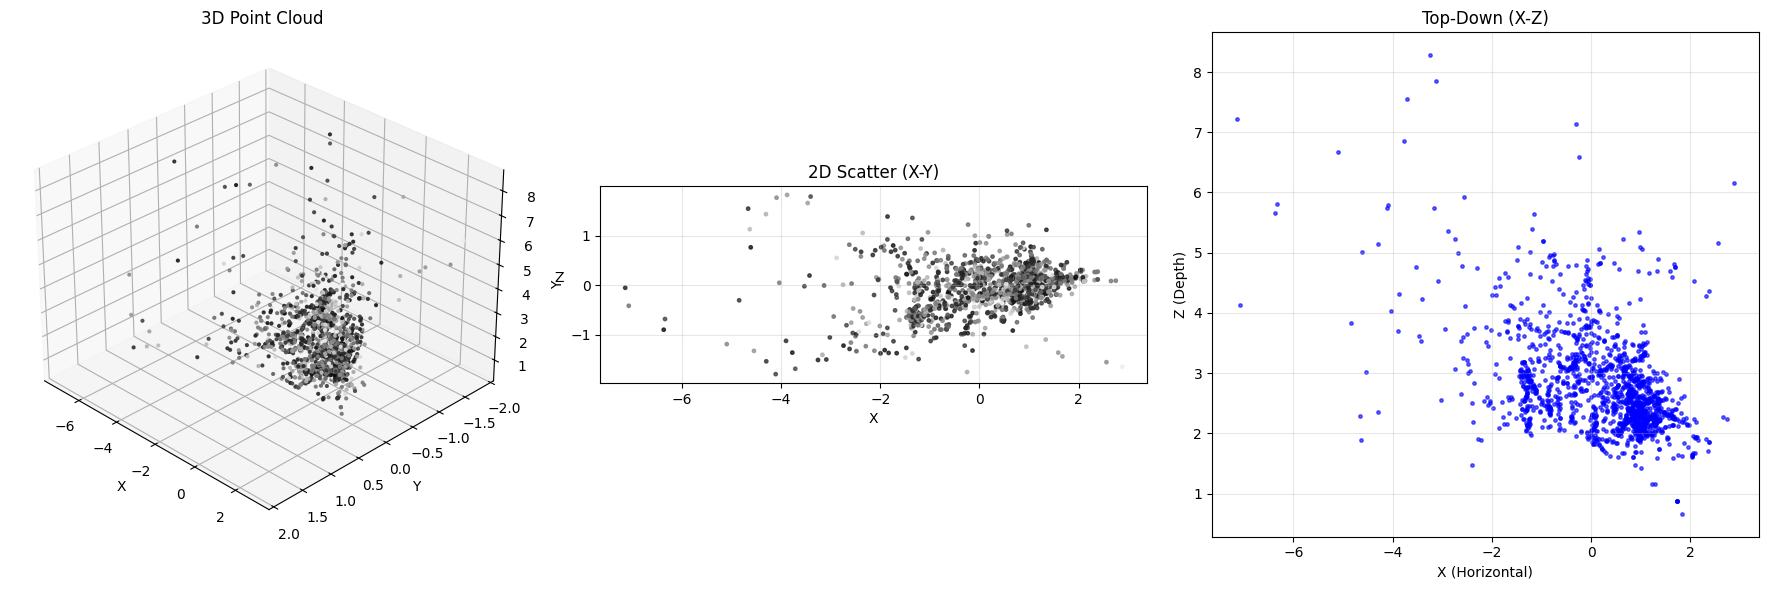

In [ ]:
import matplotlib.pyplot as plt

points_3d = np.array(sfm.point_cloud, dtype=float)
colors = None
if hasattr(sfm, 'point_colors') and len(sfm.point_colors) == len(sfm.point_cloud):
    colors = np.array(sfm.point_colors, dtype=float) / 255.0

mean = np.mean(points_3d, axis=0)
std = np.std(points_3d, axis=0)
clean_mask = (np.abs(points_3d - mean) < 3 * std).all(axis=1)
clean_points = points_3d[clean_mask]
colors_clean = colors[clean_mask] if colors is not None else None

print(f"Visualizing {len(clean_points)} points (after removing extreme outliers).")

X = clean_points[:, 0]
Y = clean_points[:, 1]
Z = clean_points[:, 2]

fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(131, projection='3d')
if colors_clean is not None:
    ax1.scatter(X, Y, Z, c=colors_clean, s=4, alpha=0.85)
else:
    scatter = ax1.scatter(X, Y, Z, c=Z, cmap='viridis', s=3, alpha=0.7)
    plt.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Point Cloud')
ax1.invert_yaxis()
ax1.view_init(elev=30, azim=-45)

ax2 = fig.add_subplot(132)
if colors_clean is not None:
    ax2.scatter(X, Y, c=colors_clean, s=6, alpha=0.8)
else:
    ax2.scatter(X, Y, c=Z, cmap='viridis', s=6, alpha=0.8)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('2D Scatter (X-Y)')
ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal', adjustable='box')

ax3 = fig.add_subplot(133)
ax3.scatter(X, Z, c='blue', s=6, alpha=0.6)
ax3.set_xlabel('X (Horizontal)')
ax3.set_ylabel('Z (Depth)')
ax3.set_title('Top-Down (X-Z)')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interactive 3D Visualization (Open3D)

In [13]:
try:
    import open3d as o3d
    import matplotlib.pyplot as plt
    import os

    use_refined = os.path.exists('reconstruction_refined.ply')
    ply_path = 'reconstruction_refined.ply' if use_refined else 'reconstruction_raw.ply'

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np.array(sfm.point_cloud, dtype=float))
    if hasattr(sfm, 'point_colors') and len(sfm.point_colors) == len(sfm.point_cloud):
        colors_np = np.array(sfm.point_colors, dtype=float) / 255.0
        pcd.colors = o3d.utility.Vector3dVector(colors_np)
    else:
        pts = np.array(sfm.point_cloud, dtype=float)
        z = pts[:, 2]
        z_norm = (z - z.min()) / max(1e-9, (z.max() - z.min()))
        colors_z = plt.cm.viridis(z_norm)[:, :3]
        pcd.colors = o3d.utility.Vector3dVector(colors_z)

    coord_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])
    bbox = pcd.get_axis_aligned_bounding_box()
    bbox.color = (1, 0.5, 0)

    print(f"✨ Launching Open3D interactive viewer with {len(sfm.point_cloud)} points...")
    o3d.visualization.draw_geometries(
        [pcd, coord_frame, bbox],
        window_name='3D Reconstruction - Interactive View',
        width=1400,
        height=1000,
        left=50,
        top=50
    )
except ImportError:
    print('⚠️  Open3D not installed. Run: pip install open3d')
except Exception as e:
    print(f'⚠️  Open3D visualization failed: {e}')

✨ Launching Open3D interactive viewer with 1649 points...
